<a href="https://colab.research.google.com/github/cloudhood/learning-basics/blob/main/notebooks/survival_analysis_2_kaplan_meier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaplan-Meier Estimation

[Run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/SurvivalAnalysisPython/blob/master/02_kaplan_meier.ipynb)

This notebook introduces Kaplan-Meier estimation, a way to estimate a hazard function when the dataset includes both complete and incomplete cases.
To demonstrate, I'll use a small set of hypothetical data.  

## Dog adoption data

Suppose you are investigating the time it takes for dogs to get adopted from a shelter.  You visit a shelter every week for 10 weeks, and record the arrival time for each dog and the adoption time for each dog that was adopted.

Here's what the data might look like.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
obs = pd.DataFrame()

obs['start'] = 0,1,2,2,4,6,7
obs['end'] = 5,2,6,9,9,8,9
obs['status'] = 1,1,1,0,0,1,0

obs

,start,end,status
0,0,5,1
1,1,2,1
2,2,6,1
3,2,9,0
4,4,9,0
5,6,8,1
6,7,9,0


This `DataFrame` contains one row for each dog and three columns:

* `start`: arrival time, in weeks since the beginning of the study

* `end`: adoption date, for dogs that were adopted, or `9` for dogs that had not been adopted at the end of the study

* `status`: `1` for dogs that were adopted; `0` for dogs that were not.

## Plotting lifelines

The following function visualizes the data.

In [3]:
def plot_lifelines(obs):
    """Plot a line for each observation.
    
    obs: DataFrame
    """
    for y, row in obs.iterrows():
        start = row['start']
        end = row['end']
        status = row['status']
        
        if status == 0:
            # ongoing
            plt.hlines(y, start, end, color='C0')
        else:
            # complete
            plt.hlines(y, start, end, color='C1')
            plt.plot(end, y, marker='o', color='C1')
            
    plt.xlabel('Time (weeks)')
    plt.ylabel('Dog index')
    plt.gca().invert_yaxis()

Here are the results:

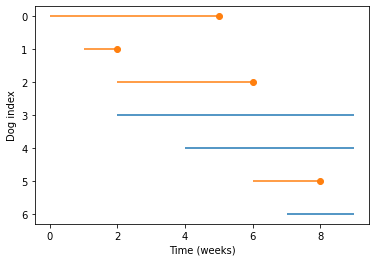

In [4]:
plot_lifelines(obs)

Each line represents the time a dog spends at the shelter. Each dot represents an adoption.
We can see, for example:

* The dog with index 0 arrived during week 0, and was adopted during week 5.

* The dog with index 3 arrived during week 2, and had not been adopted at the end of week 9.


## Estimating survival

Now suppose we want to know the distribution of "survival time" from arrival to adoption.
For the dogs that were adopted, we have all the data we need.  
For the others, we have only partial information: if a dog hasn't been adopted yet, we don't know when it will be, but we can put a lower bound on it.

When we have a **mixture of complete and incomplete observations** -- adopted and unadopted dogs -- we **can't compute the Survival function directly**.
Instead, we have to work backwards: we estimate the hazard function first, then use it to compute the survival function, CDF, and PMF.

Specifically, we'll use **Kaplan-Meier estimation**, which is based on two key ideas.

The first idea is that we can ignore the arrival time in the observed data, and **consider only the durations**.  In effect, we can take the actual lifelines and shift them so they all start at 0, like this:

In [5]:
duration = obs['end'] - obs['start']

In [6]:
shifted = obs.copy()
shifted['start'] = 0
shifted['end'] = duration

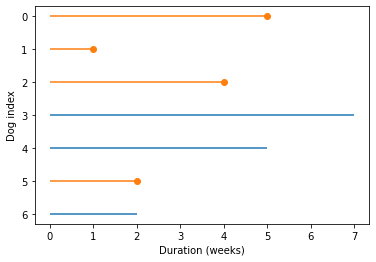

In [7]:
plot_lifelines(shifted)
plt.xlabel('Duration (weeks)');

Notice that the x-axis in this figure is duration, not time.

The second key idea is that we can estimate the hazard function by considering:

* The number of dogs adopted at each duration, divided by

* The number of dogs "at risk" at each duration, where "at risk" means that they *could* be adopted.

For example:

* At duration 1, there is 1 adoption out of 7 dogs at risk, so the hazard rate is `1/7`.

* At duration 2, there is 1 adoption out of 6 dogs at risk, so the hazard rate is `1/6`.

* At duration 4, there is 1 adoption out of 4 dogs at risk, so the hazard rate is `1/4`.

And so on. Now let's see how that works computationally.

## Computing "at risk"

For each observed duration, we would like to compute the number of dogs that were at risk.
Here are the unique durations, in order:

In [8]:
ts = duration.unique()
ts.sort()
ts

array([1, 2, 4, 5, 7])

To compute the number of dogs at risk, we can loop through `ts` and count the number of dogs where `t` is less than or equal to `end`.

In [9]:
at_risk = pd.Series(0, index=ts)

for t in ts:
    k = (t <= shifted['end'])
    at_risk[t] = k.sum()
    
at_risk

1    7
2    6
4    4
5    3
7    1
dtype: int64

If you don't like mixing for loops with array operations, we can do the same computation using mesh grids.

In [10]:
E, T = np.meshgrid(shifted['end'], ts)
T.shape

(5, 7)

The results are arrays with one row for each value of `t` and one column for each dog.
Now we can use comparison operators to compare all values of `t` to all values of `end` at the same time.

In [11]:
at_risk = (T <= E).sum(axis=1)
at_risk

array([7, 6, 4, 3, 1])

The result is an array with the number of dogs at risk for each value of `t`.

## Estimating the hazard function

Now, to compute the hazard function, we need to know the number of dogs adopted at each value of `t`.

In [12]:
adopted = pd.Series(0, index=ts)

for t in ts:
    k = (shifted['status'] == 1) & (t == shifted['end'])
    adopted[t] = k.sum()
    
adopted

1    1
2    1
4    1
5    1
7    0
dtype: int64

Or here's the same computation with array operations:

In [13]:
adopt_times = np.where(shifted['status'], shifted['end'], np.nan)
adopt_times

array([ 5.,  1.,  4., nan, nan,  2., nan])

In [14]:
A, T = np.meshgrid(adopt_times, ts)
T.shape

(5, 7)

In [15]:
adopted = (T == A).sum(axis=1)
adopted

array([1, 1, 1, 1, 0])

For the next step, it will be easier to see what we're doing if we put the results in a table.

In [16]:
d = dict(adopted=adopted, 
         at_risk=at_risk)
df = pd.DataFrame(d, index=ts)
df

,adopted,at_risk
1,1,7
2,1,6
4,1,4
5,1,3
7,0,1


Finally, the hazard function is the ratio of `adopted` and `at_risk`:

In [17]:
df['hazard'] = df['adopted'] / df['at_risk']
df

,adopted,at_risk,hazard
1,1,7,0.142857
2,1,6,0.166667
4,1,4,0.250000
5,1,3,0.333333
7,0,1,0.000000


## Working backwards

Given the hazard function, we can work backwards to compute the survival curve.

The hazard function is the probability of being adopted at each duration, so its complement is the probability of *not* being adopted. 

In order to survive past `t`, a dog has to *not* be adopted at all durations up to and including `t`.

So the survival function is the cumulative product of the complement of the hazard function.

In [18]:
df['surv'] = (1 - df['hazard']).cumprod()
df

,adopted,at_risk,hazard,surv
1,1,7,0.142857,0.857143
2,1,6,0.166667,0.714286
4,1,4,0.250000,0.535714
5,1,3,0.333333,0.357143
7,0,1,0.000000,0.357143


The CDF is the complement of the survival function.

In [19]:
df['cdf'] = 1 - df['surv']
df

,adopted,at_risk,hazard,surv,cdf
1,1,7,0.142857,0.857143,0.142857
2,1,6,0.166667,0.714286,0.285714
4,1,4,0.250000,0.535714,0.464286
5,1,3,0.333333,0.357143,0.642857
7,0,1,0.000000,0.357143,0.642857


And the PMF is the difference between adjacent elements of the CDF.

In [20]:
df['pmf'] = np.diff(df['cdf'], prepend=0)
df

,adopted,at_risk,hazard,surv,cdf,pmf
1,1,7,0.142857,0.857143,0.142857,0.142857
2,1,6,0.166667,0.714286,0.285714,0.142857
4,1,4,0.250000,0.535714,0.464286,0.178571
5,1,3,0.333333,0.357143,0.642857,0.178571
7,0,1,0.000000,0.357143,0.642857,0.000000


## lifelines

Kaplan-Meier estimation is available in a library called `lifelines`.
First I'll import it and create a `KaplanMeierFitter`.

In [21]:
# If we're running in Colab, install lifelines

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 349 kB 5.0 MB/s 
     |████████████████████████████████| 68 kB 4.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=1e0543cdd559395a11f338ca07faa69bf3672023a7f00a830599f322ccf07045
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.

In [22]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

Now we need two sequences, the durations, including complete and ongoing cases.

In [23]:
T = shifted['end']
T

0    5
1    1
2    4
3    7
4    5
5    2
6    2
Name: end, dtype: int64

And an event flag that indicates whether a case is complete.

In [24]:
E = shifted['status']

The `fit` method does the Kaplan-Meier estimation.

In [25]:
kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7 total observations, 3 right-censored observations>

Now the `Fitter` object contains the estimated survival function.

In [26]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
1.0,0.857143
2.0,0.714286
4.0,0.535714
5.0,0.357143
7.0,0.357143


`timelines` includes an element at `t=0`, but other than that it is identical to what we computed (except for floating-point error).

In [27]:
max(abs(kmf.survival_function_['KM_estimate'] - df['surv']).dropna())

1.6653345369377348e-16

`lifelines` also computes a confidence interval for the survival function.

In [28]:
ci = kmf.confidence_interval_survival_function_
ci

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,1.000000,1.000000
1.0,0.334054,0.978561
2.0,0.258154,0.919797
4.0,0.131988,0.824997
5.0,0.051977,0.698713
7.0,0.051977,0.698713


With such a small dataset, the CI is pretty wide.

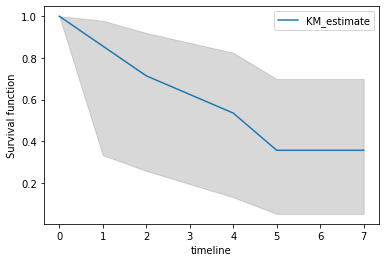

In [29]:
ts = ci.index
low, high = np.transpose(ci.values)

plt.fill_between(ts, low, high, color='gray', alpha=0.3)
kmf.survival_function_.plot(ax=plt.gca())
plt.ylabel('Survival function');

Part of [Survival Analysis in Python](https://allendowney.github.io/SurvivalAnalysisPython/)

Allen B. Downey

[Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)